# Advanced Lane Finding Project (Finding Lane line / Warp image Part3)

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## TestImage Pipeline ##

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

import pickle
import sys

import os
import pandas as pd
import matplotlib.gridspec as gridspec

import seaborn as sns

from PIL import Image
from skimage.transform import rescale, resize, rotate
from skimage.color import gray2rgb, rgb2gray
from skimage import transform, filters, exposure
from skimage.io import imread, imsave

from scipy.ndimage.interpolation import rotate

import platform

%matplotlib inline


***
##   pipelineBinaryImage definition 
***
* normal image to sobelx   
* S channel of HLS binary filtering. 
* then make binary including those 2 categorical mask 

***
##   pipelineBinaryImage2 definition 
***
* l channel of HLS applied to sobelx  
* S channel of HLS binary filtering. 
* then make binary including those 2 categorical mask

In [3]:
from utils import pipelineBinaryImage, pipelineBinaryImage2

### common function to set threshhold values ###

In [4]:
def threshold(img, thresh_min=0, thresh_max=255):
    # 
    # Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    # 
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh_min) & (img <= thresh_max)] = 1
    
    return xbinary
    

In [5]:
def region_of_interest(img, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [6]:
def rgb2gray(rgb):
    #convert rgb to gray scale
    r, g, b = rgb[:, :,:,0], rgb[:, :,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


In [7]:
def histogram_equalize(img):
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

In [8]:
def displayImage2x1(originalImage,modifiedImage,origTitle,modTitle,gray1=False, gray2=False):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    if gray1 == True:
        ax1.imshow(originalImage, cmap="gray")
    else:
        ax1.imshow(originalImage)
    ax1.set_title(origTitle, fontsize=50)

    if gray2 == True:
        ax2.imshow(modifiedImage,cmap="gray")
    else:
        ax2.imshow(modifiedImage)
    ax2.set_title(modTitle, fontsize=50)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def displayImage2x4(filenames,images,mysubtitle="Display Images",gray=False):

        gs1 = gridspec.GridSpec(4, 2)
        gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
        plt.figure(figsize=(26,22))
        plt.suptitle(mysubtitle, fontsize=24)
        for i in range(8):
            ax1 = plt.subplot(gs1[i])
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.set_aspect('equal')
            #img = transform_image(image,20,10,5,brightness=1)

            #plt.tight_layout()
            plt.subplot(4,2,i+1)
            if gray:
                plt.imshow(images[i], cmap = "gray")
            else:
                plt.imshow(images[i])
            plt.title(filenames[i],fontsize=18)
            plt.axis('off')

        plt.show()


## load saved pickle camera calibration parameters ##

In [9]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "./pickled_data/calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


# Load Test images and undistortion images from saved directory #

In [10]:
#
# load test images from test_images directory
#
# read with skimage.io.imread (RGB mode)

filenames = sorted( os.listdir("./test_images/") )
images = list( map( lambda x: imread( os.path.join("./test_images",x)), filenames) )

#undistort_filenames = sorted( os.listdir("./undistort/") )
#undistort_images = list( map( lambda x: imread( os.path.join("./undistort",x)), filenames) )

undist_ops = lambda img:cv2.undistort(img, mtx, dist, None, mtx)
undistort_images = list( map( undist_ops, images ) )


#displayImage2x4(filenames,images, "Original Test Images = 8 images ")

# reading chessboard image files #

In [11]:
# read chess board images 
imagefiles = glob.glob('./camera_cal/calibration*.jpg')
print(imagefiles)

['./camera_cal/calibration5.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration1.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration9.jpg', './camera_cal/calibration8.jpg']


## Draw the rectange lines for indentifying the lane lines on the road ##

* for the reference 

In [57]:
# check out the image shape

undistort_images[0].shape[:2]
img_size = ( images[0].shape[1], images[0].shape[0] )

In [51]:
def undistort_corners_unwarp(img, src, mtx, dist):

    # images should be undistortion based on camera calibration.
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    
    # Define 4 destination points
    
    # Mar. 10, 2018 
    # dst is selected after a number of experimental trial to find
    # what is best destination combination to show 
    # straight line of the warped image 
    dst = np.float32([[250, img.shape[0]], [250, 0], 
                      [960, 0], [960, img.shape[0]]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

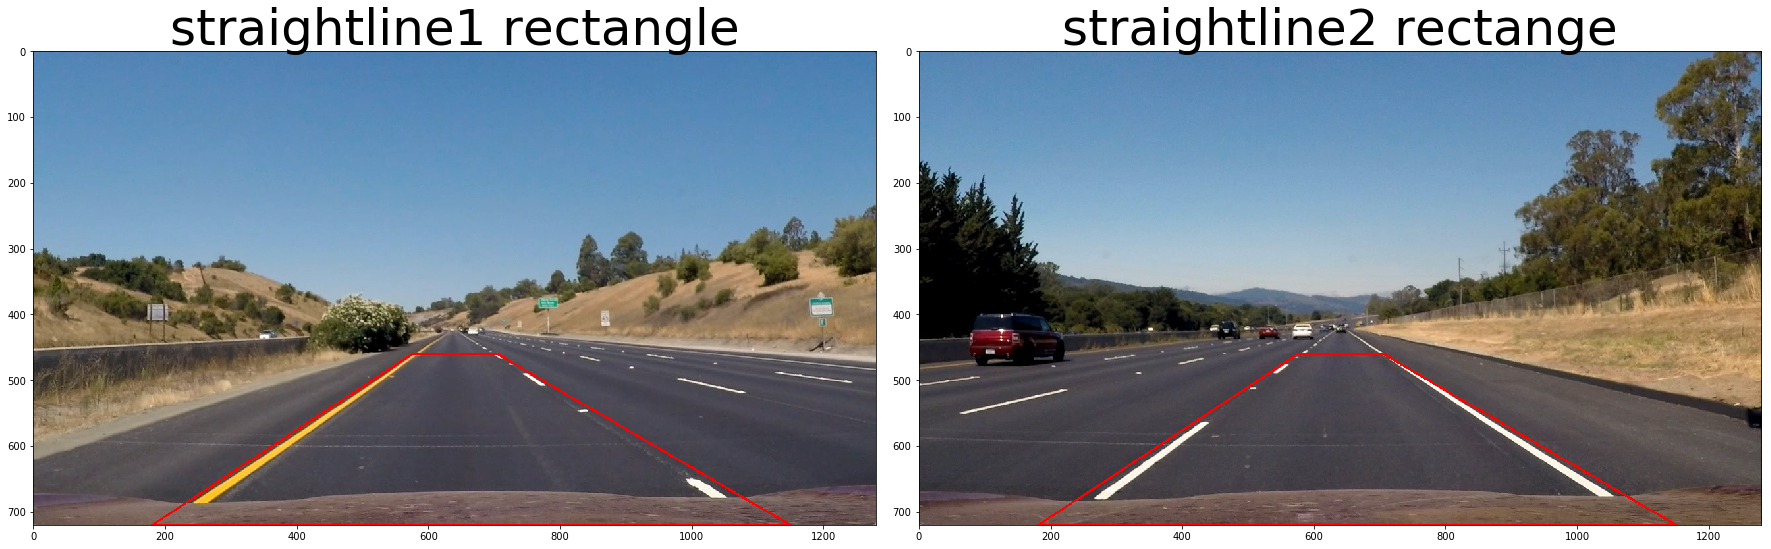

In [14]:
#
# undistort_images[0] -> straight lines road
# undistort_images[1] -> straight lines road
#
xSize, ySize = images[0].shape[:2]
straight1 = images[0].copy()
straight2 = images[1].copy()

# src is common parameter for straight1 line ...
# 180 720 is bottom left 
# 575 460 is upper left
# 705 460 is upper right 
# 1150 720 is bottom right

src = np.float32([[180, straight1.shape[0]], [575, 460], 
                  [705, 460], [1150, straight1.shape[0]]])

color = [255, 0, 0] # RED
w = 2

for st in [straight1,straight2]:
    cv2.line(st, tuple(src[0]), tuple(src[1]), color, w)
    cv2.line(st, tuple(src[1]), tuple(src[2]), color, w)
    cv2.line(st, tuple(src[2]), tuple(src[3]), color, w)
    cv2.line(st, tuple(src[3]), tuple(src[0]), color, w)

displayImage2x1(straight1,straight2,"straightline1 rectangle","straightline2 rectange")

### make warped image from original image using camera calibration parameters (mtx , dist) ###

In [52]:
straight1 = images[0].copy()
straight2 = images[1].copy()

warp_straight1, pM1, _ = undistort_corners_unwarp(straight1, src, mtx, dist)
warp_straight2, pM2, _ = undistort_corners_unwarp(straight2, src, mtx, dist)

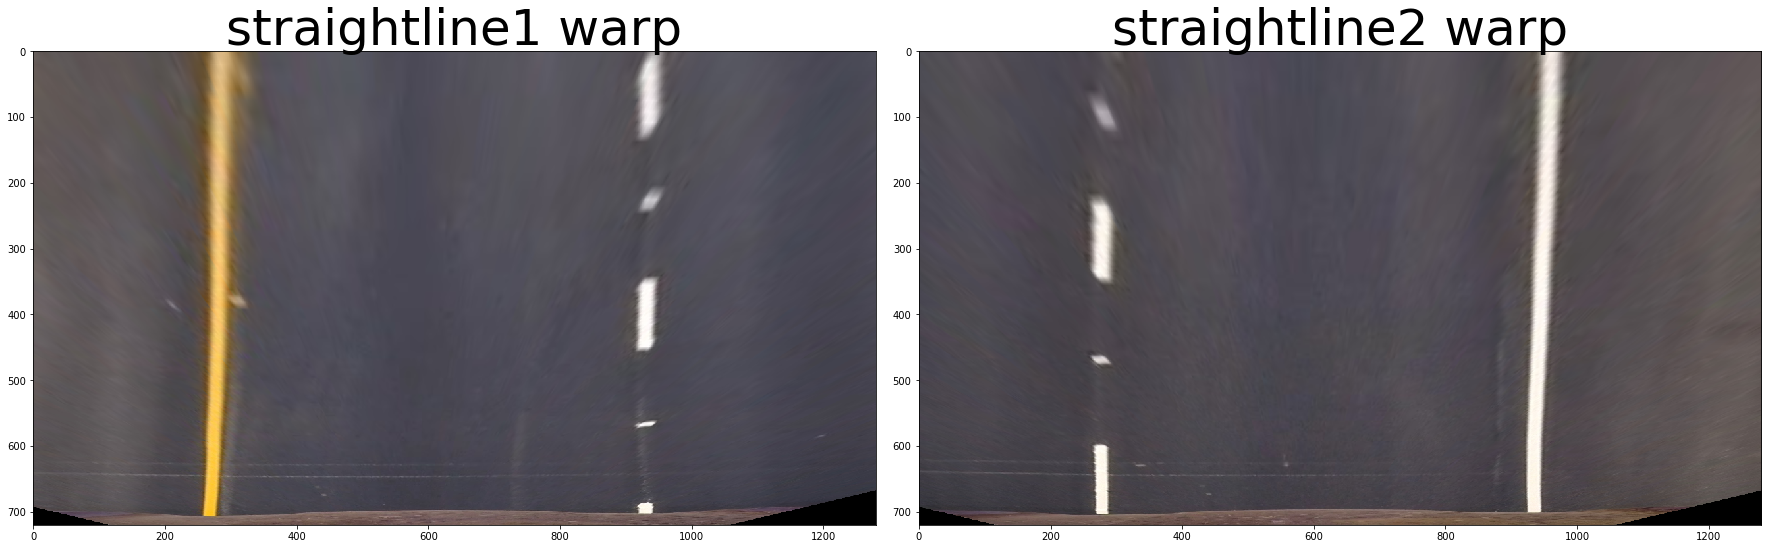

In [53]:
displayImage2x1(warp_straight1,warp_straight2,"straightline1 warp","straightline2 warp")

### show binary masking image from pipelineBinaryImage ### 

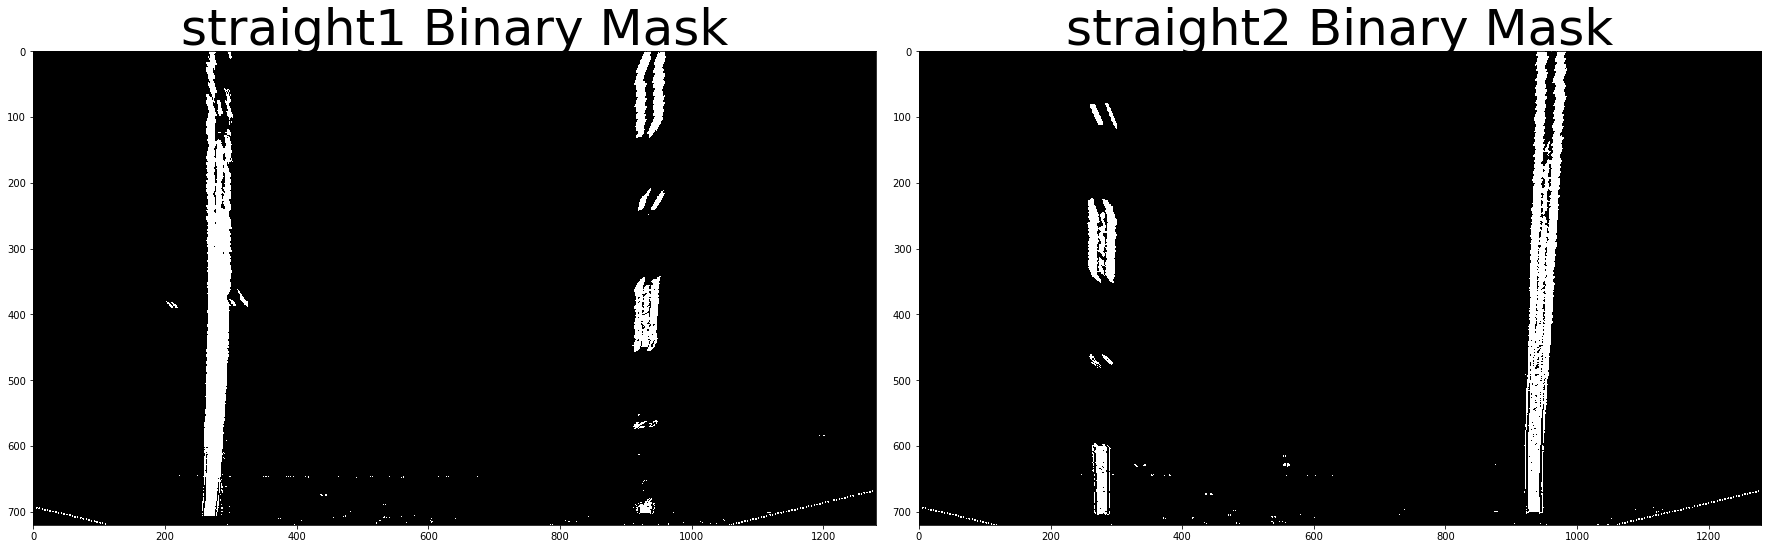

In [19]:
binary_st1 = pipelineBinaryImage(warp_straight1)
binary_st2 = pipelineBinaryImage(warp_straight2)

displayImage2x1(binary_st1,binary_st2,"straight1 Binary Mask","straight2 Binary Mask",True,True)

# Now it is time to try the curved lane line of the road #

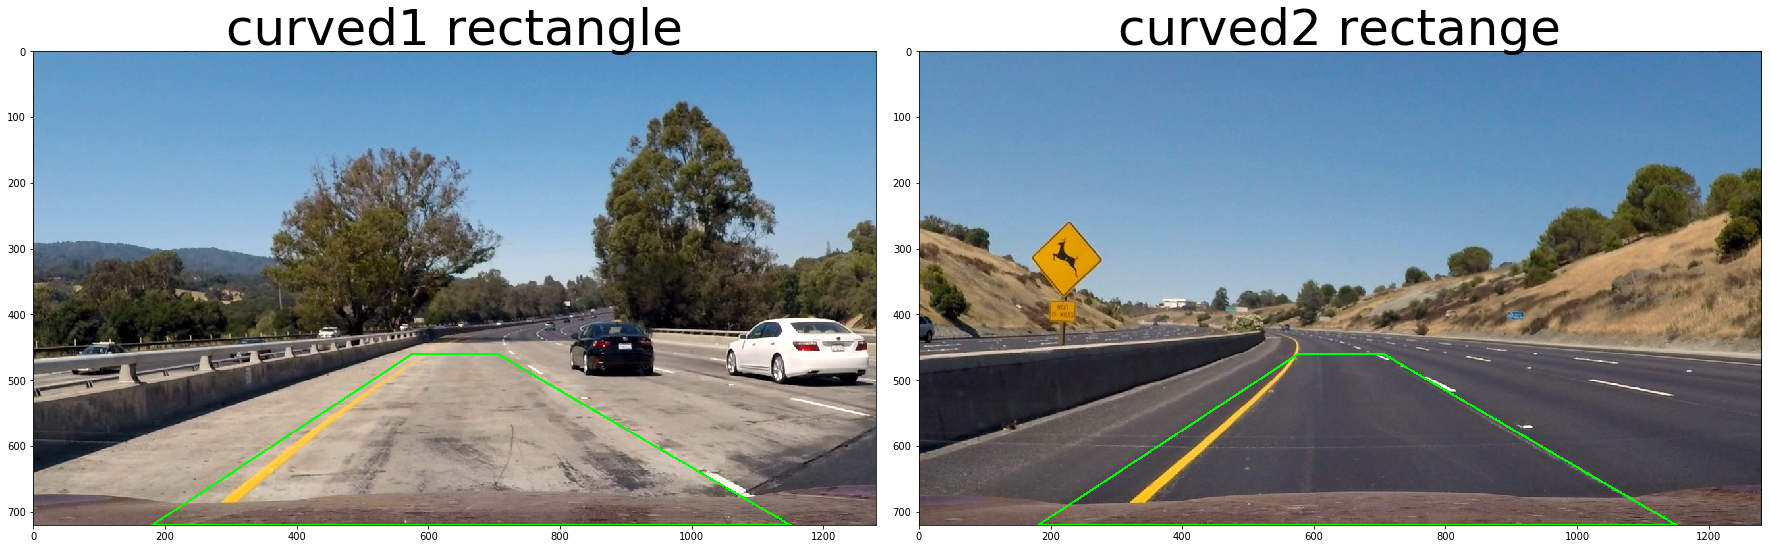

In [20]:
#
# undistort_images[2] -> curved lines road
# undistort_images[3] -> curved lines road
#
xSize, ySize = images[2].shape[:2]
curved1 = images[2].copy()
curved2 = images[3].copy()
# source points for straigt line 1 & 2

# src is common parameter for straight1 line ...

# 180 720 is bottom left 
# 575 460 is upper left
# 705 460 is upper right 
# 1150 720 is bottom right

src = np.float32([[180, straight1.shape[0]], [575, 460], 
                  [705, 460], [1150, straight1.shape[0]]])

color = [0, 255, 0] # GREEN
w = 2

for st in [curved1,curved2]:
    cv2.line(st, tuple(src[0]), tuple(src[1]), color, w)
    cv2.line(st, tuple(src[1]), tuple(src[2]), color, w)
    cv2.line(st, tuple(src[2]), tuple(src[3]), color, w)
    cv2.line(st, tuple(src[3]), tuple(src[0]), color, w)

displayImage2x1(curved1,curved2,"curved1 rectangle","curved2 rectange")

### curved line warped image ###

In [54]:
curved1 = images[2].copy()
curved2 = images[3].copy()

warp_curved1, perspective_M_crv1, Minv1 = undistort_corners_unwarp(curved1, src, mtx, dist)
warp_curved2, perspective_M_crv2, Minv2 = undistort_corners_unwarp(curved2, src, mtx, dist)

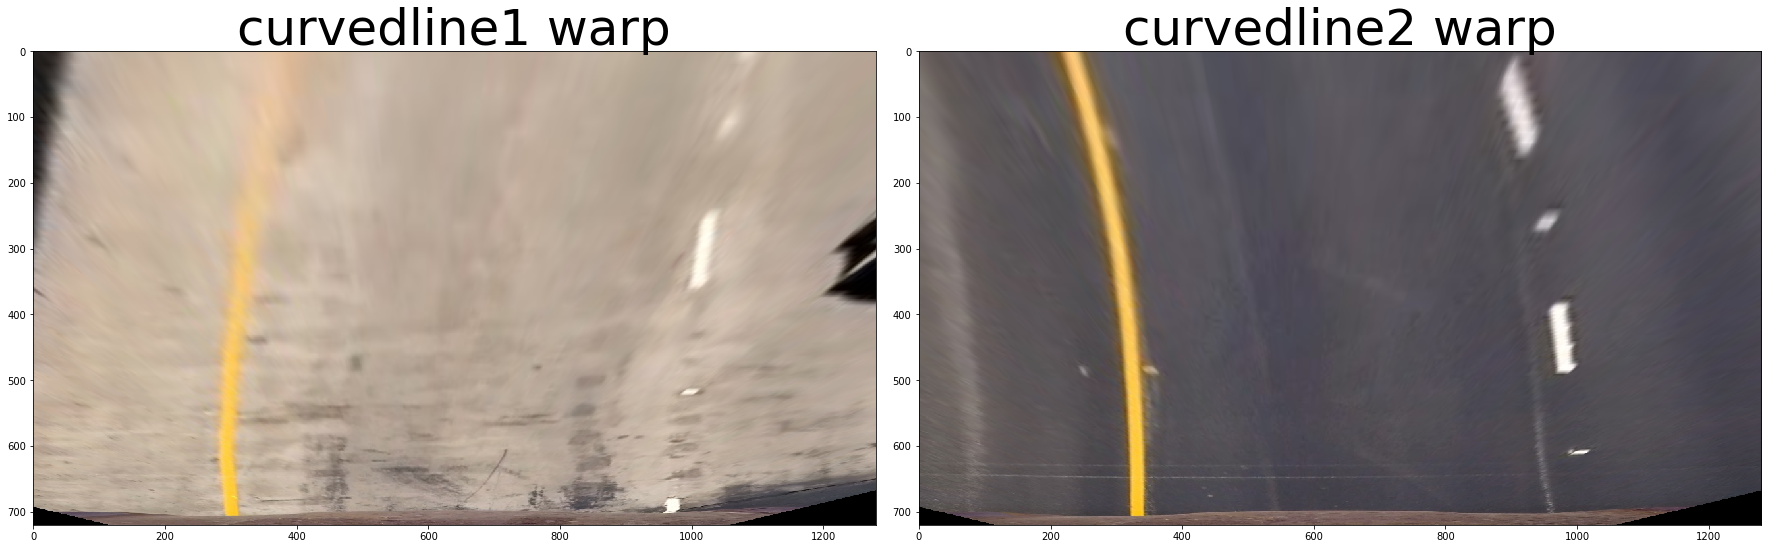

In [55]:
displayImage2x1(warp_curved1,warp_curved2,"curvedline1 warp","curvedline2 warp")

### show binary masking image for curved line ###

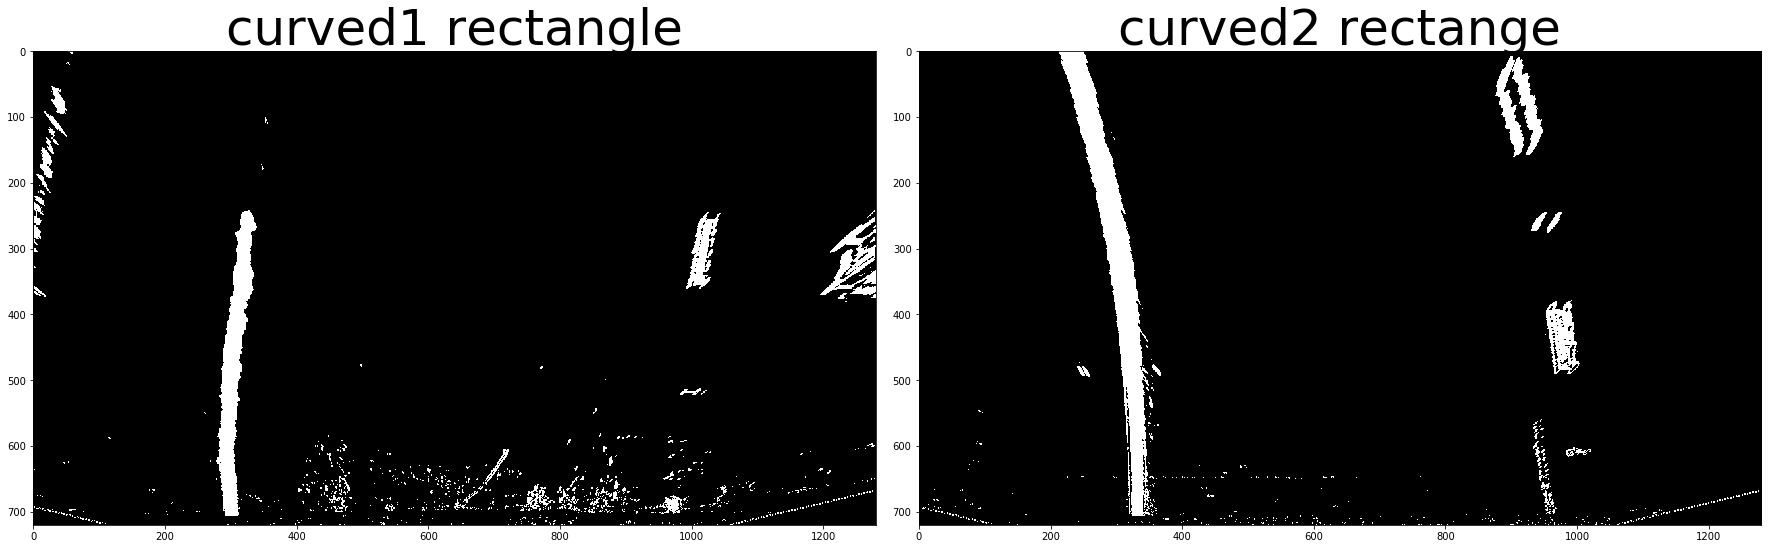

In [25]:
binary1 = pipelineBinaryImage(warp_curved1)
binary2 = pipelineBinaryImage(warp_curved2)

displayImage2x1(binary1,binary2,"curved1 rectangle","curved2 rectange",True,True)

### Check histogram of binary image axis=0 (x) from half size of image ###

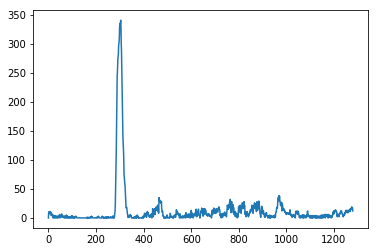

In [26]:
histogram1 = np.sum(binary1[  binary1.shape[0]//2:,:  ], axis=0)
plt.plot(histogram1)

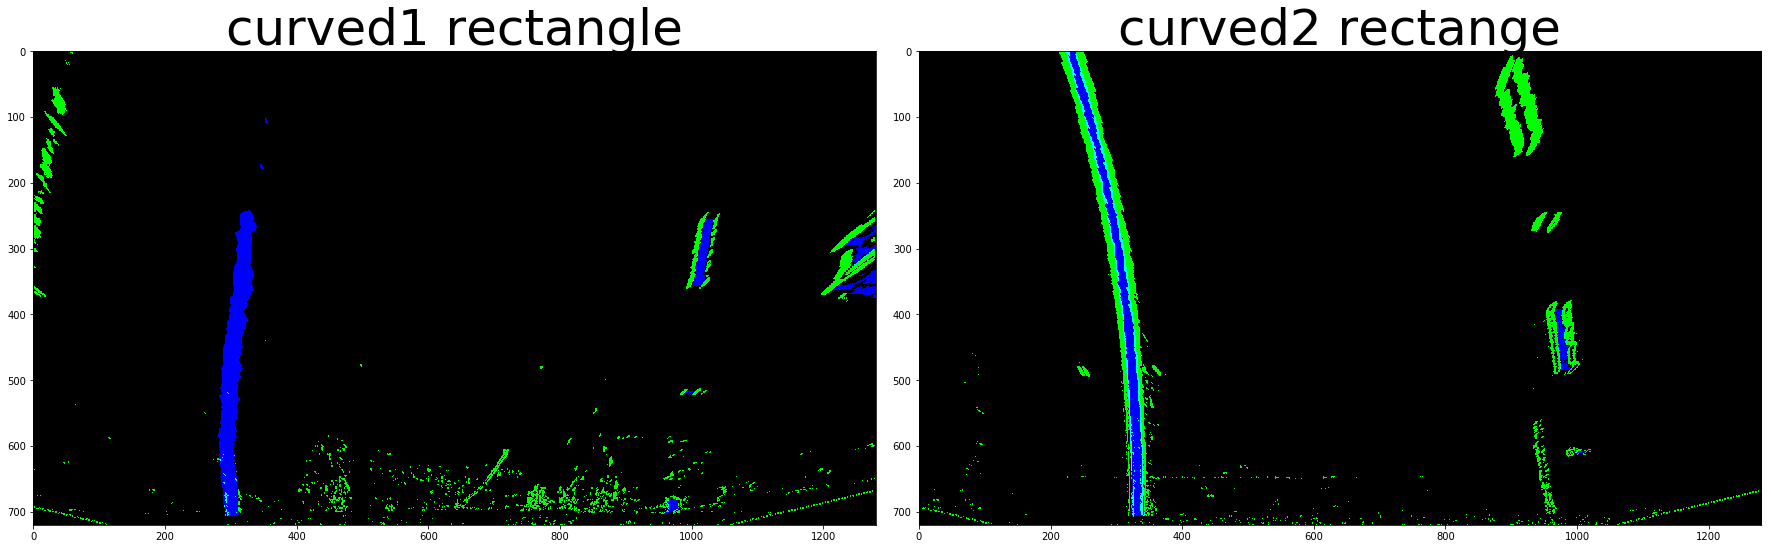

In [54]:
colored1, binary_1 = pipelineBinaryImage2(warp_curved1)
colored2, binary_2 = pipelineBinaryImage2(warp_curved2)

displayImage2x1(colored1,colored2,"curved1 rectangle","curved2 rectange")

In [27]:
def slidingWindow(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    #
    # Visualize 
    #
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fit, right_fit, out_img
    
    


(720, 0)

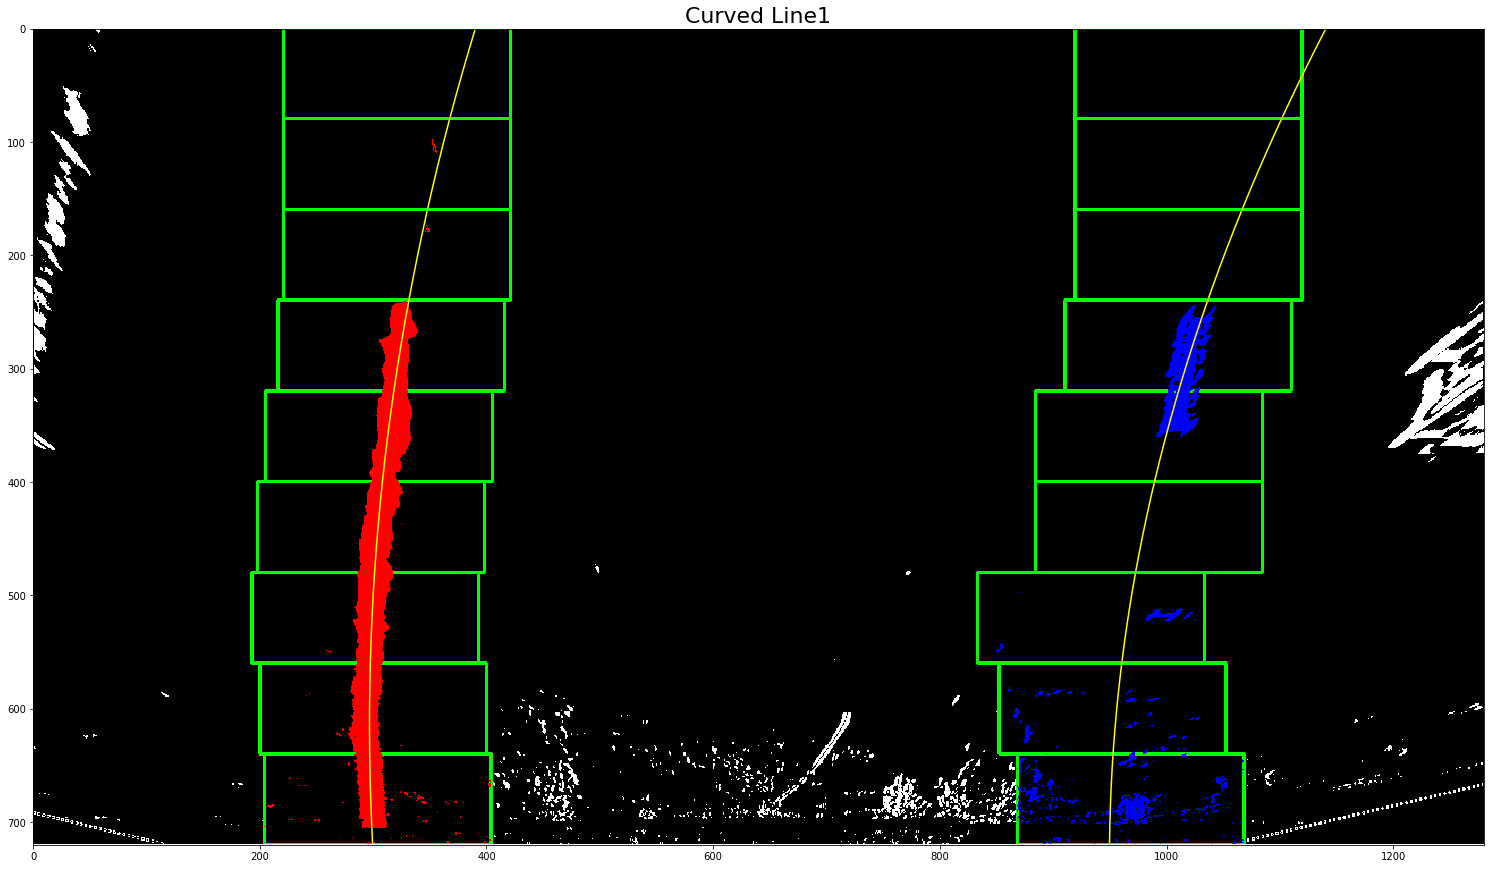

In [33]:
left_fit, right_fit, out_img = slidingWindow(binary1)

ploty = np.linspace(0, binary1.shape[0]-1, binary1.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(26,22))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("Curved Line1",fontsize="22")
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

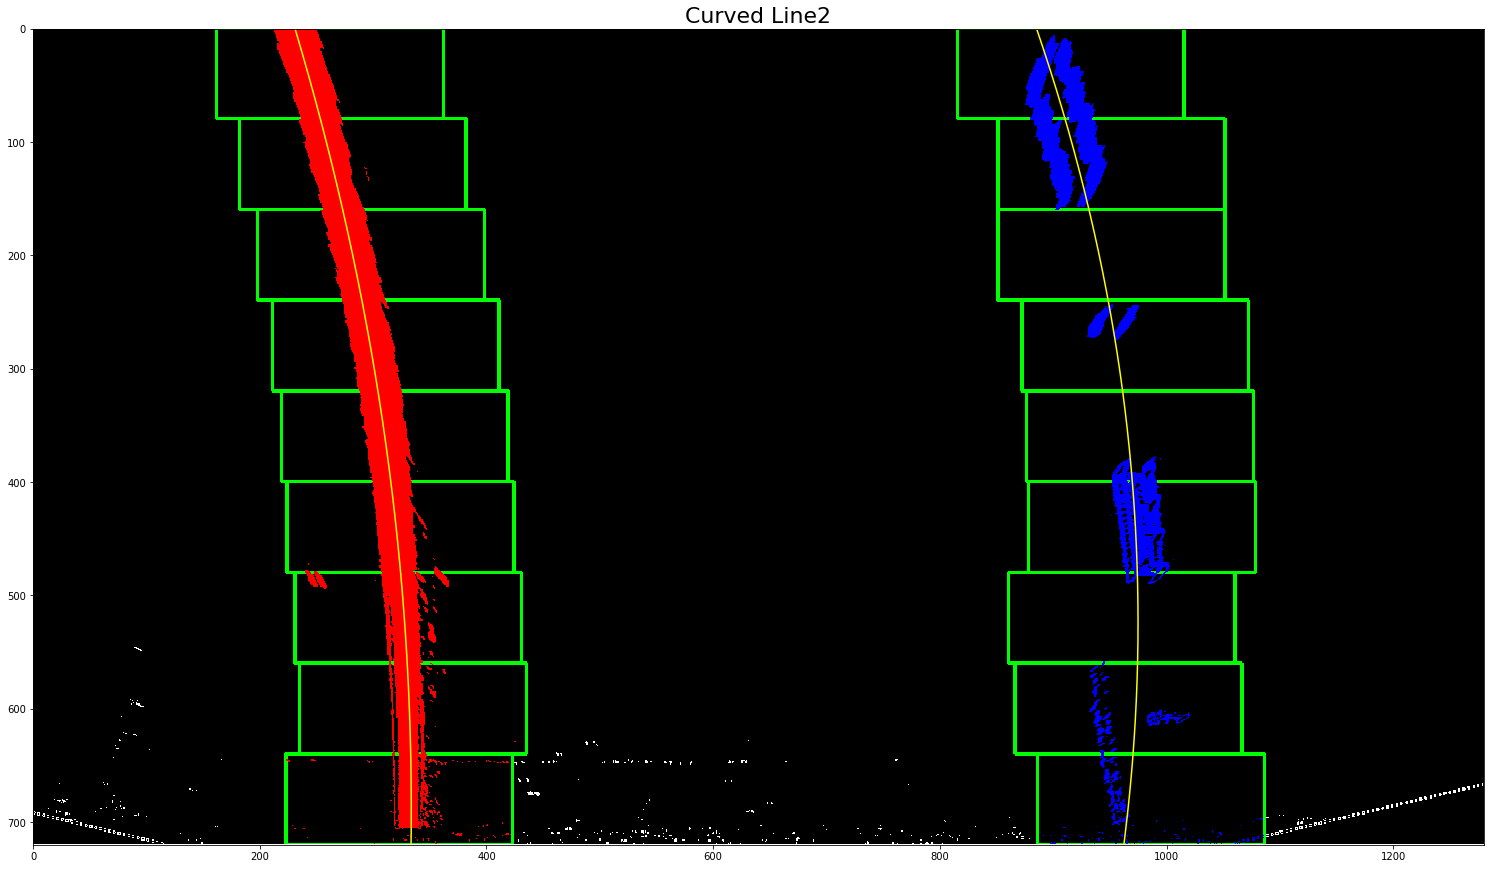

In [34]:
left_fit, right_fit, out_img = slidingWindow(binary2)

ploty = np.linspace(0, binary1.shape[0]-1, binary1.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure(figsize=(26,22))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("Curved Line2",fontsize="22")
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [30]:
binary_warped = binary2.copy()
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()

nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(array([  0,   0,   0, ..., 719, 719, 719]), array([ 212,  213,  214, ..., 1060, 1062, 1064]))
[ True  True  True ..., False False False]


(720, 0)

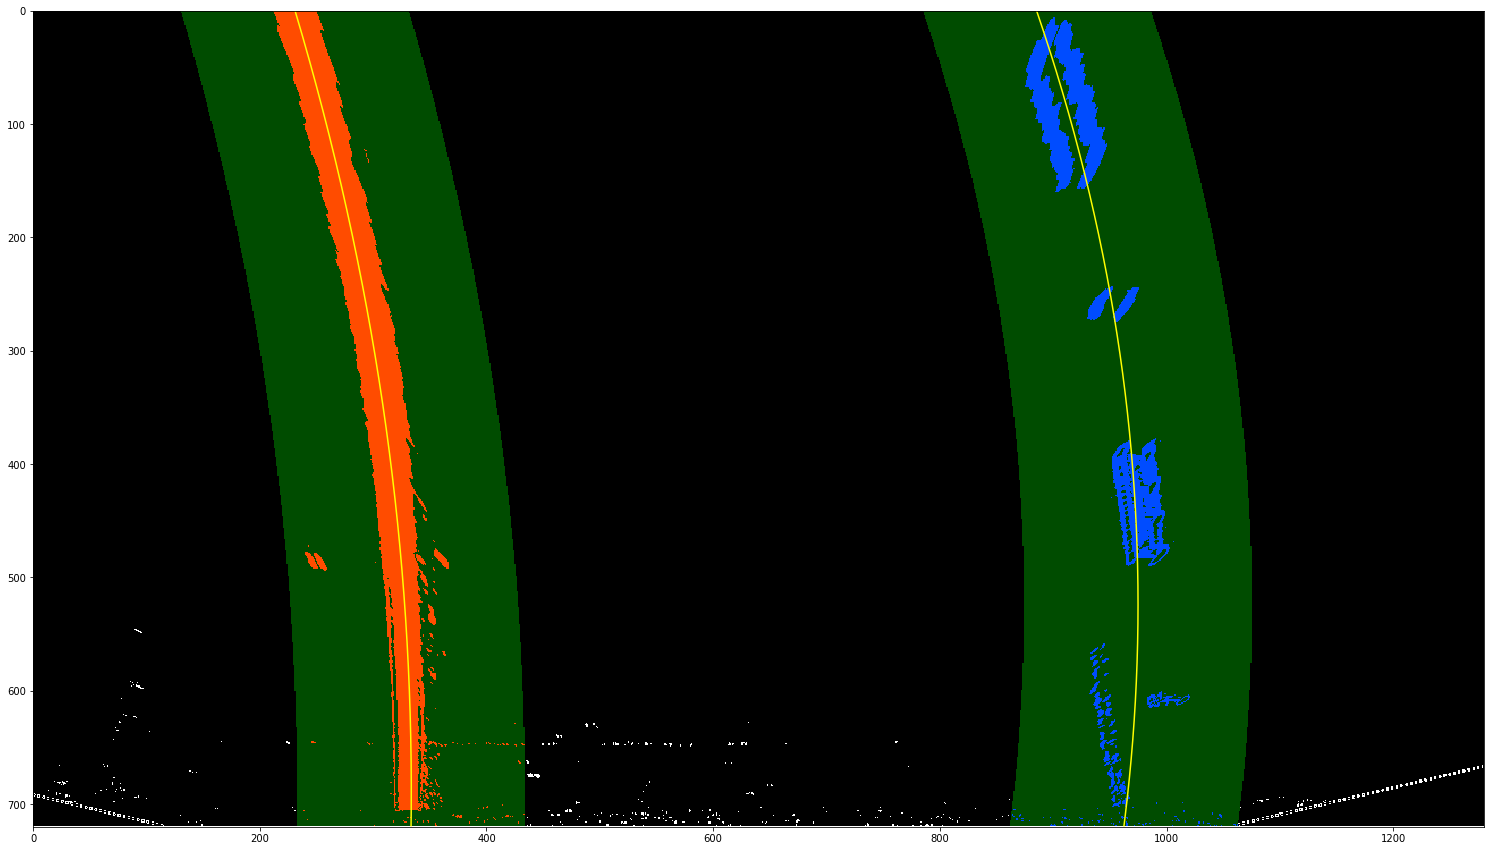

In [35]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.figure(figsize=(26,22))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Radius of Curvature ##


***

* Math Formulation is as follows
* A or B is fitting parameters. 
 $$R_{curve} = \frac{ (1 + (2Ay + B)^2) ^\frac{3}{2}  }{ |2A| } $$



In [36]:
y_eval = np.max(ploty)

In [39]:

print("left fit : ",left_fit)
print("right fit : ",right_fit)

left fit :  [ -2.16398369e-04   2.97941339e-01   2.31132762e+02]
right fit :  [ -3.25964777e-04   3.41583443e-01   8.85382543e+02]


In [40]:
# y_eval = maximum y value of input image 720 - 1 px( starting 0 )

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

2311.16099058 1571.25863174


In [46]:
## So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720.0 # meters per pixel in y dimension
xm_per_pix = 3.7/700.0 # meters per pixel in x dimension

In [47]:
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

In [48]:

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

758.91247334 m 504.014045213 m


In [49]:
# %% Warp the detected lane boundaries back onto the original image
# # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(result, np.int_([pts]), (0,255, 0))


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

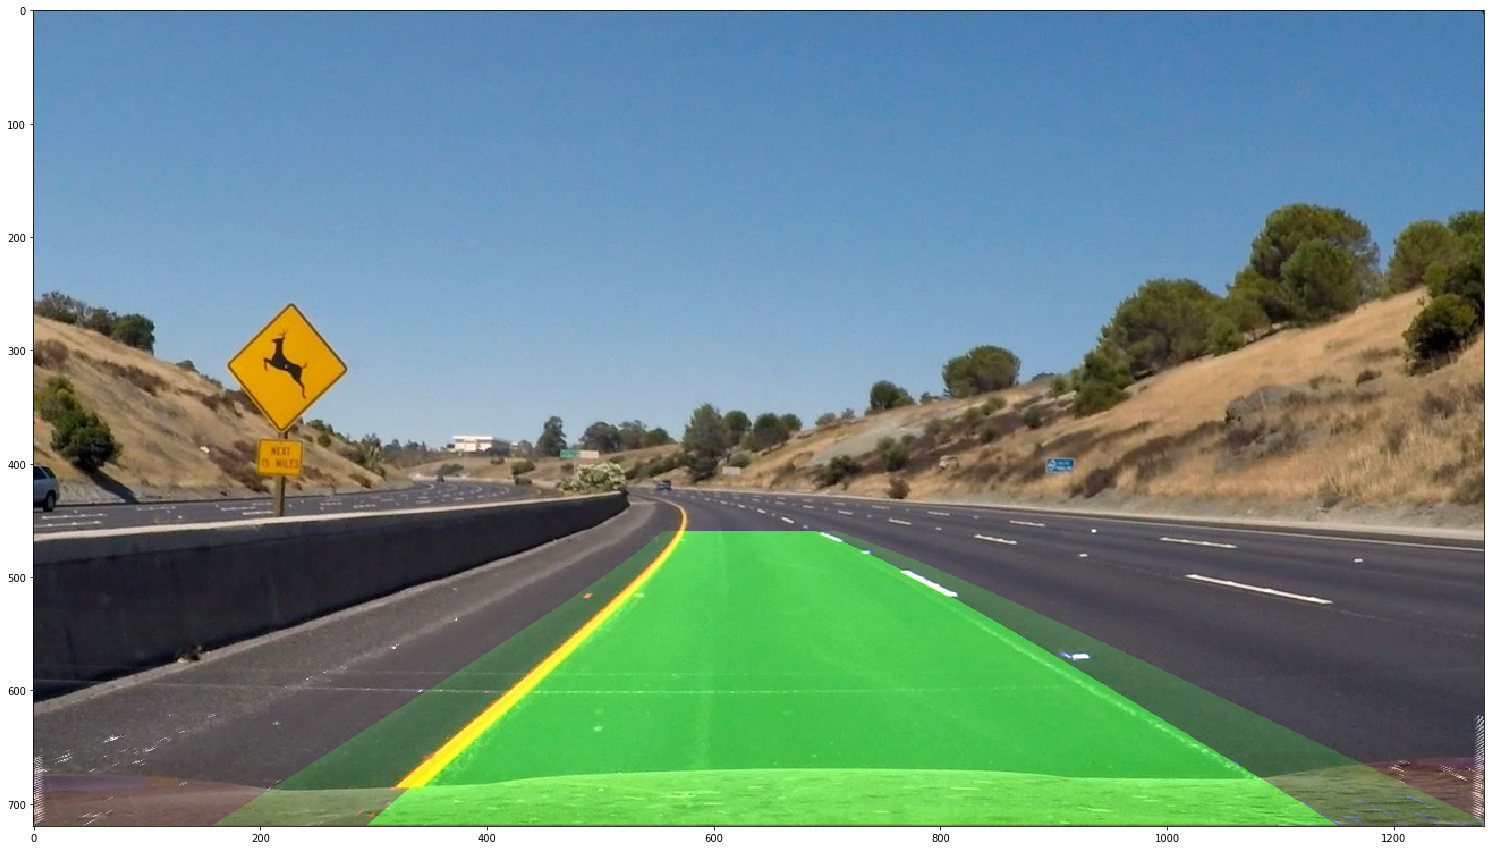

In [59]:
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(result, Minv2, (img_size[0], img_size[1])) 

newwarp = np.uint8(newwarp)

# Combine the result with the original image
final = cv2.addWeighted(curved2, 1, newwarp, 0.5, 0)
plt.figure(figsize=(26,22))
plt.imshow(final)